# Dependencies Installation

In [ ]:
!pip install awscli
!aws s3 ls --no-sign-request s3://multiconer/multiconer2023/

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
                           PRE BN-Bangla/
                           PRE DE-German/
                           PRE EN-English/
                           PRE ES-Spanish/
                           PRE FA-Farsi/
                           PRE FR-French/
                           PRE HI-Hindi/
                           PRE IT-Italian/
                           PRE MULTI-Multilingual/
                           PRE PT-Portuguese/
                           PRE SV-Swedish/
                           PRE UK-Ukrainian/
                           PRE ZH-Chinese/
2023-02-15 04:19:25          0 
2023-02-21 04:07:02       3279 readme.md


In [ ]:
!aws s3 cp s3://multiconer/multiconer2023/EN-English  ./multiconer2023 --recursive --no-sign-request

download: s3://multiconer/multiconer2023/EN-English/en_dev.conll to multiconer2023/en_dev.conll
download: s3://multiconer/multiconer2023/EN-English/en_train.conll to multiconer2023/en_train.conll
download: s3://multiconer/multiconer2023/EN-English/en_test.conll to multiconer2023/en_test.conll


In [ ]:
!pip3 install stanza

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [ ]:
!pip install sklearn-crfsuite

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


# Import Dependencies

In [ ]:
import pandas as pd
from argparse import ArgumentParser
import json
import glob
import os
from os.path import join
import stanza
import nltk

from itertools import chain

import sklearn
import scipy.stats
import re
import math, string, re

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from collections import Counter

import sys
if sys.version_info[0] >= 3:
    unicode = str

from num2words import num2words

# Data Generation

In [ ]:
def process(in_path, o_path, mode):
    dataset = []
    domain_ds = read_conllu(in_path, mode)
    sents = [obj['tokens'] for obj in domain_ds]
    domain = domain_ds[0]['domain']
    dataset.extend(domain_ds)

    ds_json = json.dumps(dataset, ensure_ascii=False, indent=4)

    if not os.path.exists(o_path):
        os.makedirs(o_path)

    with open(join(o_path, f'{mode}.json'), 'w', encoding='utf8') as outfile:
        outfile.write(ds_json)

def read_conllu(filename, mode):
    dataset = []
    flag = 0
    with open(filename, encoding='utf-8') as f:
        sentence = []
        ner_tags = []
        obj = {}
        for row in f:
            row = row.strip()

            # This sentence is complete, add to list and initialize next one
            if len(row) == 0 and len(sentence) > 0:
                obj['tokens'] = sentence
                
                if mode!="test_data":
                    obj['ner_tags'] = ner_tags
                dataset.append(obj)
                sentence = []
                ner_tags = []
                obj = {}
            
            elif len(row) == 0:
              continue

            # If it is a comment, add the data to the object
            elif row[0] == '#' and len(row.split()) == 4:
                obj['id'] = row.split()[2]
                obj['domain'] = row.split()[3].split('=')[1]

            # If it is not a comment, add words to sentence
            else:
                sentence.append(row.split()[0])
                if mode!="test_data":
                    ner_tags.append(row.split()[3])
                
    return dataset

In [ ]:
!zip -r data.zip /kaggle/working/multiconer2023/data
from IPython.display import FileLink
FileLink(r'data.zip')

In [ ]:
# # CONVERT AND SAVE COLL FILES AS JSON FILES
# process("/Users/siddharthgorayan/NLP/multiconer2023/en_train.conll","/Users/siddharthgorayan/NLP/multiconer2023/data","train_data")
# process("/Users/siddharthgorayan/NLP/multiconer2023/en_test.conll","/Users/siddharthgorayan/NLP/multiconer2023/data","test_data")
# process("/Users/siddharthgorayan/NLP/multiconer2023/en_dev.conll","/Users/siddharthgorayan/NLP/multiconer2023/data","dev_data")

# OPEN JSON FILES
trainFile = open('/Users/siddharthgorayan/NLP/multiconer2023/data/train_data.json')
testFile = open('/Users/siddharthgorayan/NLP/multiconer2023/data/test_data.json')
devFile = open('/Users/siddharthgorayan/NLP/multiconer2023/data/dev_data.json')

# LOAD JSON FILES
trainData = json.load(trainFile)
testData = json.load(testFile)
devData = json.load(devFile)

# MAKE pd DATAFRAMES
trainData = pd.DataFrame(trainData)
testData = pd.DataFrame(testData)
devData = pd.DataFrame(devData)

# Data Analysis & Pre-processing

In [ ]:
trainData.head()

,id,domain,tokens,ner_tags
0,309f5b26-951e-472b-948e-47632249862b,en,"[robert, gottschalk, 1939, academy, award, win...","[B-OtherPER, I-OtherPER, O, B-VisualWork, I-Vi..."
1,bb81b9a7-e73d-4977-b6a8-0f7937123dfe,en,"[during, the, reign, of, the, tongzhi, emperor...","[O, O, O, O, O, B-OtherPER, I-OtherPER, O, O, ..."
2,d79d2f50-bf45-47c5-96b5-73c3d0ce8914,en,"[further, research, led, in, the, 1960s, to, t...","[O, O, O, O, O, O, O, O, B-OtherPER, O, O, O, ..."
3,6a65789e-e0ff-4263-8bd7-e56b836854c6,en,"[the, ideas, were, introduced, by, william, bu...","[O, O, O, O, O, B-OtherPER, I-OtherPER, O, O, ..."
4,f3723a6e-426a-4bd3-aa54-41158fab71f2,en,"[thaddeus, mosley, (, a&s, 1950, ), –, sculpto...","[B-OtherPER, I-OtherPER, O, O, O, O, O, O, O, ..."


In [ ]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16778 entries, 0 to 16777
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        16778 non-null  object
 1   domain    16778 non-null  object
 2   tokens    16778 non-null  object
 3   ner_tags  16778 non-null  object
dtypes: object(4)
memory usage: 524.4+ KB


In [ ]:
testData.head()

,id,domain,tokens
0,d9b2af7f-1110-468e-a64c-75a3c7d07f6a,en,"[the, species, was, described, by, dietrich, b..."
1,6032c2ff-03f7-44a9-91e1-2ba9ce703152,en,"[by, this, time, she, was, competing, against,..."
2,4dd21f7a-325a-4937-b851-b249db4bfcd4,en,"[their, son, was, the, opera, producer, knut, ..."
3,6f32f179-4e1a-4d5e-a695-bbdeb115aa7a,en,"[he, is, the, younger, brother, of, adam, moss..."
4,ab4b8aab-c368-4b00-b39b-b73eb47a4bf0,en,"[smes, :, laura, j., van, 't, veer, et, al, .,..."


In [ ]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249980 entries, 0 to 249979
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      174986 non-null  object
 1   domain  174986 non-null  object
 2   tokens  249980 non-null  object
dtypes: object(3)
memory usage: 5.7+ MB


In [ ]:
devData.head()

,id,domain,tokens,ner_tags
0,5239d808-f300-46ea-aa3b-5093040213a3,en,"[eli, lilly, founder, president, of, pharmaceu...","[B-OtherPER, I-OtherPER, O, O, O, O, O, B-Publ..."
1,d7d47dfc-7e5d-48e8-9390-019a3e9476c1,en,"[christoph, haberland, designed, a, new, marbl...","[B-OtherPER, I-OtherPER, O, O, O, O, B-OtherPR..."
2,7051b30d-a8e5-4bc3-a83a-eacc863f94d0,en,"[he, was, succeeded, as, chancellor, by, sir, ...","[O, O, O, O, O, O, B-OtherPER, I-OtherPER, I-O..."
3,6c63b565-b3d4-4c2d-b4a7-6a00460f0d32,en,"[it, was, described, by, edward, meyrick, in, ...","[O, O, O, O, B-OtherPER, I-OtherPER, O, O, O]"
4,de7f8c86-2f0b-4a8c-b119-bab3958ef379,en,"[having, suffered, depredation, of, the, more,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
devData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         871 non-null    object
 1   domain     871 non-null    object
 2   tokens     871 non-null    object
 3   ner_tags   871 non-null    object
 4   pos        871 non-null    object
 5   sentences  871 non-null    object
dtypes: object(6)
memory usage: 41.0+ KB


In [ ]:
# PREPROCESSING
def preprocessing(data, dataType):
    data = data.drop_duplicates(subset=['id'])
    data = data.reset_index()
    data = data.drop(columns=['index'])

    posTags = []
    for i in range(len(data['id'])):
        posTags.append([tag[1] for tag in nltk.pos_tag(data['tokens'][i])])

    data['pos'] = posTags

    if dataType != 'test':
        sentences = []
        for i in range(len(data['id'])):
            sentences.append([(w,p,t) for w,p,t in zip(data['tokens'][i], data['pos'][i], data['ner_tags'][i])])
            
        data['sentences'] = sentences

    else:
        sentences = []
        for i in range(len(data['id'])):
            sentences.append([(w,p) for w,p in zip(data['tokens'][i], data['pos'][i])])
            
        data['sentences'] = sentences
    return data

trainData = preprocessing(trainData, 'train')
testData = preprocessing(testData, 'test')
devData = preprocessing(devData, 'dev')


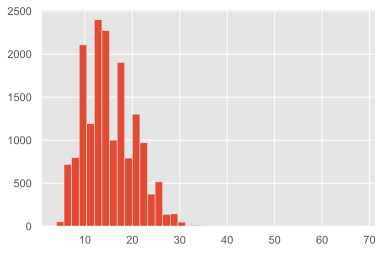

In [ ]:
plt.style.use("ggplot")
plt.hist([len(s) for s in trainData['sentences']], bins=40)
plt.show()

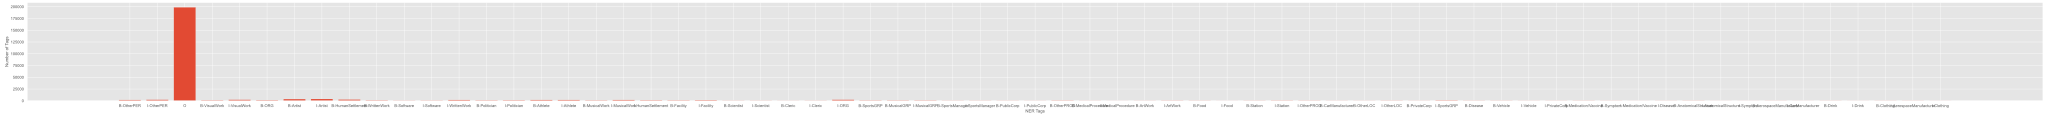

In [ ]:
plt.figure(figsize=(100, 5))
x = list(Counter([tag for i in range(len(trainData)) for tag in trainData['ner_tags'][i]]).keys())
y = list(Counter([tag for i in range(len(trainData)) for tag in trainData['ner_tags'][i]]).values())
     
plt.bar(x, y)

plt.xlabel("NER Tags")
plt.ylabel("Number of Tags")

plt.show()

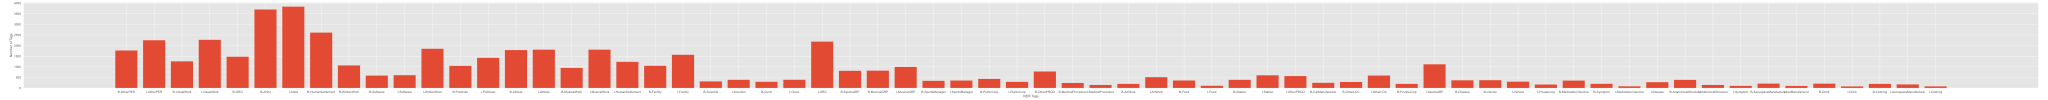

In [ ]:
plt.figure(figsize=(100, 5))
x = list(Counter([tag for i in range(len(trainData)) for tag in trainData['ner_tags'][i] if tag!='O']).keys())
y = list(Counter([tag for i in range(len(trainData)) for tag in trainData['ner_tags'][i] if tag!='O']).values())
     
plt.bar(x, y)

plt.xlabel("NER Tags")
plt.ylabel("Number of Tags")
plt.show()


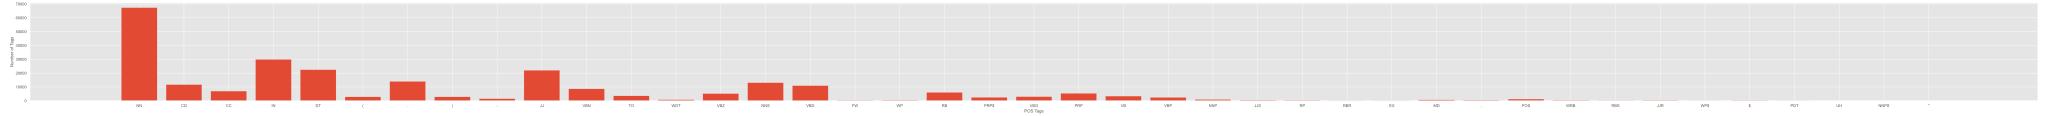

In [ ]:
plt.figure(figsize=(100, 5))
x = list(Counter([tag for i in range(len(trainData)) for tag in trainData['pos'][i]]).keys())
y = list(Counter([tag for i in range(len(trainData)) for tag in trainData['pos'][i]]).values())
     
plt.bar(x, y)

plt.xlabel("POS Tags")
plt.ylabel("Number of Tags")

plt.show()

# Design 1.1
1. Include Basic Features
2. Doesn't Include the POS Tags
3. Doesn't Include the Neighbours

In [ ]:
def token2features(sent, i, includeNeighbours = True):
    features = []
    features.append("BIAS")
    if i == 0:
        features.append("SENT_BEGIN")
    if i == len(sent)-1:
        features.append("SENT_END")
    word = unicode(sent[i][0])
    features.append("WORD=" + word)
    features.append("LCASE=" + word.lower())
    if word.isalnum():
        features.append("IS_ALNUM")
    if word.isnumeric():
        features.append("IS_NUMERIC")
    if word.isdigit():
        features.append("IS_DIGIT")
    if word.isupper():
        features.append("IS_UPPER")
    if word.islower():
        features.append("IS_LOWER")

    features.append("WORD LENGTH :"+str(len(word)-1))
    features.append("HASH LENGTH :" + str(hash(word.split(" ")[0])))
    features.append("BYTE LENGTH OF WORD : " + num2words(sys.getsizeof(word)).upper())

    if includeNeighbours:
        if i > 0:
            for pf in token2features(sent, i-1, includeNeighbours = False):
                features.append("PREV_" + pf)
        if i < len(sent)-1:
            for pf in token2features(sent, i+1, includeNeighbours = False):
                features.append("NEXT_" + pf)

    return features
    

In [ ]:
def sent2features(sent):
    return [token2features(sent, i, False) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [ ]:
xTrain = [sent2features(s) for s in trainData['sentences']]
print('xTrain Done!')
yTrain= [sent2labels(s) for s in trainData['sentences']]
print('yTrain Done!')

xTest = [sent2features(s) for s in testData['sentences']]
print('xTest Done!')

xDev = [sent2features(s) for s in devData['sentences']]
print('xDev Done!')
yDev= [sent2labels(s) for s in devData['sentences']]
print('yDev Done!')

xTrain Done!
yTrain Done!
xTest Done!
xDev Done!
yDev Done!


In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)


yPred = crf.predict(xDev)
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

print(flat_classification_report(yDev, yPred))

0.8374918744199129


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

B-AerospaceManufacturer       0.83      1.00      0.91        10
  B-AnatomicalStructure       0.73      0.47      0.57        17
              B-ArtWork       0.33      0.08      0.12        13
               B-Artist       0.52      0.42      0.47       212
              B-Athlete       0.32      0.35      0.34        79
      B-CarManufacturer       0.67      0.62      0.64        13
               B-Cleric       0.67      0.27      0.38        15
             B-Clothing       0.33      0.20      0.25        10
              B-Disease       0.67      0.44      0.53        18
                B-Drink       1.00      0.64      0.78        11
             B-Facility       0.69      0.42      0.52        52
                 B-Food       0.67      0.11      0.18        19
      B-HumanSettlement       0.70      0.57      0.63       109
     B-MedicalProcedure       0.57      0.31      0.40        13
   B-Medication/Vaccine 

#### Accuracy = 83.75%

In [ ]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-25:])

Top likely transitions:
B-OtherPER -> I-OtherPER 9.269596
B-VisualWork -> I-VisualWork 9.237240
B-Athlete -> I-Athlete 8.927542
B-Artist -> I-Artist 8.886703
B-MusicalWork -> I-MusicalWork 8.702484
B-Politician -> I-Politician 8.630520
B-SportsManager -> I-SportsManager 8.432652
B-Scientist -> I-Scientist 8.387587
I-VisualWork -> I-VisualWork 8.211373
B-Station -> I-Station 8.198393
B-Symptom -> I-Symptom 8.046428
B-Vehicle -> I-Vehicle 7.962678
B-PrivateCorp -> I-PrivateCorp 7.945918
B-Facility -> I-Facility 7.945054
I-OtherLOC -> I-OtherLOC 7.750329
B-OtherLOC -> I-OtherLOC 7.709143
B-SportsGRP -> I-SportsGRP 7.628062
I-MusicalWork -> I-MusicalWork 7.623863
B-Software -> I-Software 7.574762
B-Cleric -> I-Cleric 7.565195
B-MusicalGRP -> I-MusicalGRP 7.461403
B-OtherPROD -> I-OtherPROD 7.310766
B-WrittenWork -> I-WrittenWork 7.262970
B-AerospaceManufacturer -> I-AerospaceManufacturer 7.231925
B-ArtWork -> I-ArtWork 7.216672

Top unlikely transitions:
O      -> I-AnatomicalStructure -3.

In [ ]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(25))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-25:])


Top positive:
3.638054 O        BIAS
3.414941 B-MusicalWork SENT_BEGIN
3.380467 O        WORD=(
3.380467 O        LCASE=(
3.380467 O        HASH LENGTH :7086382793724479447
3.362176 I-HumanSettlement WORD=gambia
3.362176 I-HumanSettlement LCASE=gambia
3.362176 I-HumanSettlement HASH LENGTH :3210560711133128436
3.332455 O        WORD=.
3.332455 O        LCASE=.
3.332455 O        HASH LENGTH :-4878038689541994620
3.178334 B-Clothing WORD=pilasters
3.178334 B-Clothing LCASE=pilasters
3.178334 B-Clothing HASH LENGTH :7550911120274172461
3.166991 B-PrivateCorp WORD=chanel
3.166991 B-PrivateCorp LCASE=chanel
3.166991 B-PrivateCorp HASH LENGTH :3772175556194252132
3.119624 B-Athlete SENT_BEGIN
3.105391 B-OtherPER WORD=987
3.105391 B-OtherPER LCASE=987
3.105391 B-OtherPER HASH LENGTH :-8959499096150331244
3.024316 B-PublicCorp WORD=netflix
3.024316 B-PublicCorp LCASE=netflix
3.024316 B-PublicCorp HASH LENGTH :-1733365619114362801
2.927610 I-CarManufacturer WORD=poppe

Top negative:
-1.128922 B

# Design 1.2
1. Include Basic Features
2. Doesn't Include the POS Tags
3. Include the Neighbours

In [ ]:
def sent2features(sent):
    return [token2features(sent, i, True) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [ ]:
xTrain = [sent2features(s) for s in trainData['sentences']]
print('xTrain Done!')
yTrain= [sent2labels(s) for s in trainData['sentences']]
print('yTrain Done!')

xTest = [sent2features(s) for s in testData['sentences']]
print('xTest Done!')

xDev = [sent2features(s) for s in devData['sentences']]
print('xDev Done!')
yDev= [sent2labels(s) for s in devData['sentences']]
print('yDev Done!')

xTrain Done!
yTrain Done!
xTest Done!
xDev Done!
yDev Done!


In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)


yPred = crf.predict(xDev)
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

print(flat_classification_report(yDev, yPred))

0.8530822898869219
                         precision    recall  f1-score   support

B-AerospaceManufacturer       1.00      0.80      0.89        10
  B-AnatomicalStructure       0.70      0.41      0.52        17
              B-ArtWork       0.00      0.00      0.00        13
               B-Artist       0.61      0.56      0.58       212
              B-Athlete       0.41      0.44      0.42        79
      B-CarManufacturer       0.67      0.46      0.55        13
               B-Cleric       0.67      0.27      0.38        15
             B-Clothing       1.00      0.10      0.18        10
              B-Disease       0.64      0.39      0.48        18
                B-Drink       0.83      0.45      0.59        11
             B-Facility       0.60      0.35      0.44        52
                 B-Food       0.00      0.00      0.00        19
      B-HumanSettlement       0.73      0.61      0.66       109
     B-MedicalProcedure       0.57      0.31      0.40        13
   B-

#### Accuracy = 85.31% : An increase of 1.56% after including neighbours.

In [ ]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-25:])

print("Top positive features:")
print_state_features(Counter(crf.state_features_).most_common(25))

print("\nTop negative features:")
print_state_features(Counter(crf.state_features_).most_common()[-25:])

Top likely transitions:
B-Politician -> I-Politician 9.306213
B-Athlete -> I-Athlete 8.515707
B-Facility -> I-Facility 8.469655
B-SportsGRP -> I-SportsGRP 8.104795
B-VisualWork -> I-VisualWork 8.032536
B-SportsManager -> I-SportsManager 8.024745
B-MusicalGRP -> I-MusicalGRP 7.952814
B-OtherPER -> I-OtherPER 7.889186
B-Station -> I-Station 7.805459
B-ORG  -> I-ORG   7.673776
B-OtherLOC -> I-OtherLOC 7.545882
B-Scientist -> I-Scientist 7.519929
B-WrittenWork -> I-WrittenWork 7.518361
B-PrivateCorp -> I-PrivateCorp 7.500083
B-Vehicle -> I-Vehicle 7.435788
B-Cleric -> I-Cleric 7.362656
B-OtherPROD -> I-OtherPROD 7.326283
B-MusicalWork -> I-MusicalWork 7.249131
B-Disease -> I-Disease 7.229618
B-Symptom -> I-Symptom 7.219736
B-PublicCorp -> I-PublicCorp 7.179074
I-HumanSettlement -> I-HumanSettlement 7.118264
B-MedicalProcedure -> I-MedicalProcedure 7.107957
I-PrivateCorp -> I-PrivateCorp 7.037275
B-HumanSettlement -> I-HumanSettlement 6.926456

Top unlikely transitions:
O      -> I-MedicalP

# Design 1.2.1
We'll keep the design 1.2 same, but would remove the BYTE_LENGTH_OF_WORD feature since it has continuously been seen as a negative feature.

In [ ]:
def token2features(sent, i, includeNeighbours = True):
    features = []
    features.append("BIAS")
    if i == 0:
        features.append("SENT_BEGIN")
    if i == len(sent)-1:
        features.append("SENT_END")
    word = unicode(sent[i][0])
    features.append("WORD=" + word)
    features.append("LCASE=" + word.lower())
    if word.isalnum():
        features.append("IS_ALNUM")
    if word.isnumeric():
        features.append("IS_NUMERIC")
    if word.isdigit():
        features.append("IS_DIGIT")
    if word.isupper():
        features.append("IS_UPPER")
    if word.islower():
        features.append("IS_LOWER")

    features.append("WORD LENGTH :"+str(len(word)-1))
    features.append("HASH LENGTH :" + str(hash(word.split(" ")[0])))

    if includeNeighbours:
        if i > 0:
            for pf in token2features(sent, i-1, includeNeighbours = False):
                features.append("PREV_" + pf)
        if i < len(sent)-1:
            for pf in token2features(sent, i+1, includeNeighbours = False):
                features.append("NEXT_" + pf)

    return features
    

In [ ]:
xTrain = [sent2features(s) for s in trainData['sentences']]
print('xTrain Done!')
yTrain= [sent2labels(s) for s in trainData['sentences']]
print('yTrain Done!')

xTest = [sent2features(s) for s in testData['sentences']]
print('xTest Done!')

xDev = [sent2features(s) for s in devData['sentences']]
print('xDev Done!')
yDev= [sent2labels(s) for s in devData['sentences']]
print('yDev Done!')

xTrain Done!
yTrain Done!
xTest Done!
xDev Done!
yDev Done!


In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)


yPred = crf.predict(xDev)
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

print(flat_classification_report(yDev, yPred))

0.8528624975711175


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

B-AerospaceManufacturer       1.00      0.80      0.89        10
  B-AnatomicalStructure       0.67      0.35      0.46        17
              B-ArtWork       0.00      0.00      0.00        13
               B-Artist       0.63      0.57      0.60       212
              B-Athlete       0.41      0.44      0.43        79
      B-CarManufacturer       0.67      0.46      0.55        13
               B-Cleric       0.67      0.27      0.38        15
             B-Clothing       1.00      0.10      0.18        10
              B-Disease       0.64      0.39      0.48        18
                B-Drink       0.83      0.45      0.59        11
             B-Facility       0.55      0.31      0.40        52
                 B-Food       0.00      0.00      0.00        19
      B-HumanSettlement       0.74      0.59      0.66       109
     B-MedicalProcedure       0.67      0.31      0.42        13
   B-Medication/Vaccine 

#### The accuracy decreased from 85.31 to 85.28. So we keep the BYTE LENGTH feature as well as it would give a negative weight to the feature, ignoring it and hence not learning it by mistake also

In [ ]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-25:])

print("Top positive features:")
print_state_features(Counter(crf.state_features_).most_common(25))

print("\nTop negative features:")
print_state_features(Counter(crf.state_features_).most_common()[-25:])

Top likely transitions:
B-OtherPER -> I-OtherPER 9.508307
B-Athlete -> I-Athlete 8.950644
B-Politician -> I-Politician 8.723876
B-Artist -> I-Artist 8.309933
B-SportsGRP -> I-SportsGRP 7.767391
B-Station -> I-Station 7.711561
B-SportsManager -> I-SportsManager 7.646248
B-OtherLOC -> I-OtherLOC 7.571475
B-PublicCorp -> I-PublicCorp 7.544486
B-OtherPROD -> I-OtherPROD 7.478481
B-WrittenWork -> I-WrittenWork 7.464580
B-Symptom -> I-Symptom 7.436591
B-Cleric -> I-Cleric 7.432953
B-Scientist -> I-Scientist 7.261667
B-Facility -> I-Facility 7.048422
B-Food -> I-Food  7.046493
B-AerospaceManufacturer -> I-AerospaceManufacturer 7.044278
B-Disease -> I-Disease 7.037222
B-PrivateCorp -> I-PrivateCorp 7.034421
B-MedicalProcedure -> I-MedicalProcedure 6.973869
B-Medication/Vaccine -> I-Medication/Vaccine 6.968035
I-OtherLOC -> I-OtherLOC 6.916070
B-MusicalWork -> I-MusicalWork 6.858858
B-ArtWork -> I-ArtWork 6.856499
B-Clothing -> I-Clothing 6.823768

Top unlikely transitions:
O      -> I-Food  -3

# Design 2.1
1. Include Basic Features
2. Include the POS Tags
3. Doesn't Include the Neighbours

In [ ]:
def token2features(sent, i, includeNeighbours = True):
    features = []
    features.append("BIAS")
    if i == 0:
        features.append("SENT_BEGIN")
    if i == len(sent)-1:
        features.append("SENT_END")
    word = unicode(sent[i][0])
    postag = unicode(sent[i][1])
    features.append("WORD=" + word)
    features.append("POS=" + postag)
    features.append("LCASE=" + word.lower())
    if word.isalnum():
        features.append("IS_ALNUM")
    if word.isnumeric():
        features.append("IS_NUMERIC")
    if word.isdigit():
        features.append("IS_DIGIT")
    if word.isupper():
        features.append("IS_UPPER")
    if word.islower():
        features.append("IS_LOWER")

    features.append("WORD LENGTH :"+str(len(word)-1))
    features.append("HASH LENGTH :" + str(hash(word.split(" ")[0])))
    features.append("BYTE LENGTH OF WORD : " + num2words(sys.getsizeof(word)).upper())

    if includeNeighbours:
        if i > 0:
            for pf in token2features(sent, i-1, includeNeighbours = False):
                features.append("PREV_" + pf)
        if i < len(sent)-1:
            for pf in token2features(sent, i+1, includeNeighbours = False):
                features.append("NEXT_" + pf)

    return features
    

In [ ]:
def sent2features(sent):
    return [token2features(sent, i, False) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [ ]:
xTrain = [sent2features(s) for s in trainData['sentences']]
print('xTrain Done!')
yTrain= [sent2labels(s) for s in trainData['sentences']]
print('yTrain Done!')

xTest = [sent2features(s) for s in testData['sentences']]
print('xTest Done!')

xDev = [sent2features(s) for s in devData['sentences']]
print('xDev Done!')
yDev= [sent2labels(s) for s in devData['sentences']]
print('yDev Done!')

xTrain Done!
yTrain Done!
xTest Done!
xDev Done!
yDev Done!


In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)


yPred = crf.predict(xDev)
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

print(flat_classification_report(yDev, yPred))

0.8421678655631871
                         precision    recall  f1-score   support

B-AerospaceManufacturer       0.91      1.00      0.95        10
  B-AnatomicalStructure       0.75      0.53      0.62        17
              B-ArtWork       0.50      0.08      0.13        13
               B-Artist       0.49      0.47      0.48       212
              B-Athlete       0.33      0.35      0.34        79
      B-CarManufacturer       0.64      0.54      0.58        13
               B-Cleric       0.67      0.27      0.38        15
             B-Clothing       0.38      0.30      0.33        10
              B-Disease       0.54      0.39      0.45        18
                B-Drink       1.00      0.55      0.71        11
             B-Facility       0.60      0.40      0.48        52
                 B-Food       0.67      0.11      0.18        19
      B-HumanSettlement       0.74      0.61      0.67       109
     B-MedicalProcedure       0.62      0.38      0.48        13
   B-

#### Accuracy = 84.21%
#### This shows that compared to Design 1.1 where we did not include the POS Tags, the accuracy increases from 83.75% to 84.21%. But compared to Design 1.2 where we included the neighbours, the accuracy decreases from 85.31% to 84.21%.
#### Therefore we observe that we should include both POS Tags and Neighbours in order to get best results.

In [ ]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-25:])

print("Top positive features:")
print_state_features(Counter(crf.state_features_).most_common(25))

print("\nTop negative features:")
print_state_features(Counter(crf.state_features_).most_common()[-25:])

Top likely transitions:
B-Athlete -> I-Athlete 13.446426
B-WrittenWork -> I-WrittenWork 9.223950
B-MusicalWork -> I-MusicalWork 9.038776
B-Politician -> I-Politician 9.000882
B-Artist -> I-Artist 8.742810
I-WrittenWork -> I-WrittenWork 8.630787
I-MusicalWork -> I-MusicalWork 8.489905
B-ORG  -> I-ORG   8.346698
B-Scientist -> I-Scientist 8.312467
B-OtherPER -> I-OtherPER 8.166672
B-SportsManager -> I-SportsManager 7.996224
B-Vehicle -> I-Vehicle 7.936781
B-SportsGRP -> I-SportsGRP 7.757855
B-Cleric -> I-Cleric 7.669289
B-Facility -> I-Facility 7.639061
B-Disease -> I-Disease 7.611887
B-Station -> I-Station 7.602710
B-VisualWork -> I-VisualWork 7.547075
B-OtherPROD -> I-OtherPROD 7.545926
B-PrivateCorp -> I-PrivateCorp 7.534020
I-ORG  -> I-ORG   7.526925
B-Symptom -> I-Symptom 7.476075
B-PublicCorp -> I-PublicCorp 7.435657
B-HumanSettlement -> I-HumanSettlement 7.299271
B-MusicalGRP -> I-MusicalGRP 7.274378

Top unlikely transitions:
O      -> I-WrittenWork -3.159805
O      -> I-SportsMa

# Design 2.2
1. Include Basic Features
2. Include the POS Tags
3. Include the Neighbours

In [ ]:
def sent2features(sent):
    return [token2features(sent, i, True) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [ ]:
xTrain = [sent2features(s) for s in trainData['sentences']]
print('xTrain Done!')
yTrain= [sent2labels(s) for s in trainData['sentences']]
print('yTrain Done!')

xTest = [sent2features(s) for s in testData['sentences']]
print('xTest Done!')

xDev = [sent2features(s) for s in devData['sentences']]
print('xDev Done!')
yDev= [sent2labels(s) for s in devData['sentences']]
print('yDev Done!')

xTrain Done!
yTrain Done!
xTest Done!
xDev Done!
yDev Done!


In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)


yPred = crf.predict(xDev)
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

print(flat_classification_report(yDev, yPred))

0.8561507711570862


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

B-AerospaceManufacturer       1.00      0.70      0.82        10
  B-AnatomicalStructure       0.71      0.29      0.42        17
              B-ArtWork       0.00      0.00      0.00        13
               B-Artist       0.59      0.58      0.59       212
              B-Athlete       0.45      0.49      0.47        79
      B-CarManufacturer       0.62      0.38      0.48        13
               B-Cleric       0.67      0.27      0.38        15
             B-Clothing       1.00      0.10      0.18        10
              B-Disease       0.55      0.33      0.41        18
                B-Drink       0.83      0.45      0.59        11
             B-Facility       0.66      0.40      0.50        52
                 B-Food       1.00      0.05      0.10        19
      B-HumanSettlement       0.71      0.61      0.65       109
     B-MedicalProcedure       0.67      0.31      0.42        13
   B-Medication/Vaccine 

#### Accuracy = 85.61, which is better than all previous designs.

In [ ]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-25:])

print("Top positive features:")
print_state_features(Counter(crf.state_features_).most_common(25))

print("\nTop negative features:")
print_state_features(Counter(crf.state_features_).most_common()[-25:])

# Design 3
1. Include Basic Features
2. Include the POS Tags
3. Include the Neighbours
4. Added suffix symbols context

In [ ]:
def token2features(sent, i, includeNeighbours = True):
    features = []
    features.append("BIAS")
    if i == 0:
        features.append("SENT_BEGIN")
    if i == len(sent)-1:
        features.append("SENT_END")
    word = unicode(sent[i][0])
    postag = unicode(sent[i][1])
    features.append("WORD=" + word)
    features.append("POS=" + postag)
    features.append("LCASE=" + word.lower())
    if word.isalnum():
        features.append("IS_ALNUM")
    if word.isnumeric():
        features.append("IS_NUMERIC")
    if word.isdigit():
        features.append("IS_DIGIT")
    if word.isupper():
        features.append("IS_UPPER")
    if word.islower():
        features.append("IS_LOWER")

    # Identifying the context through suffix symbols.
    if "!"  in word :
        features.append("HAS_A_EXCLAIMATION_MARK")

    if word.startswith("@") :
        if len( word[1:] ) != 0:
            features.append("IS_HEADER")
        else:
            features.append("IS_NOT_HEADER")

    if "?"  in word :
        features.append("HAS_A_QUESTION_MARK")

    if word.startswith("#") :
        if  len( word[1:] )!=0:
            features.append("IS_A_HASHTAG")
        else:
            features.append("IS_NOT_A_HASHTAG")

    features.append("WORD LENGTH :"+str(len(word)-1))
    features.append("HASH LENGTH :" + str(hash(word.split(" ")[0])))
    features.append("BYTE LENGTH OF WORD : " + num2words(sys.getsizeof(word)).upper())

    if includeNeighbours:
        if i > 0:
            for pf in token2features(sent, i-1, includeNeighbours = False):
                features.append("PREV_" + pf)
        if i < len(sent)-1:
            for pf in token2features(sent, i+1, includeNeighbours = False):
                features.append("NEXT_" + pf)

    return features
    

In [ ]:
def sent2features(sent):
    return [token2features(sent, i, True) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [ ]:
xTrain = [sent2features(s) for s in trainData['sentences']]
print('xTrain Done!')
yTrain= [sent2labels(s) for s in trainData['sentences']]
print('yTrain Done!')

xTest = [sent2features(s) for s in testData['sentences']]
print('xTest Done!')

xDev = [sent2features(s) for s in devData['sentences']]
print('xDev Done!')
yDev= [sent2labels(s) for s in devData['sentences']]
print('yDev Done!')

xTrain Done!
yTrain Done!
xTest Done!
xDev Done!
yDev Done!


In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)


yPred = crf.predict(xDev)
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

print(flat_classification_report(yDev, yPred))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-25:])

print("Top positive features:")
print_state_features(Counter(crf.state_features_).most_common(25))

print("\nTop negative features:")
print_state_features(Counter(crf.state_features_).most_common()[-25:])

0.8553360384330293


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

B-AerospaceManufacturer       1.00      0.70      0.82        10
  B-AnatomicalStructure       0.62      0.29      0.40        17
              B-ArtWork       0.00      0.00      0.00        13
               B-Artist       0.61      0.57      0.59       212
              B-Athlete       0.43      0.51      0.47        79
      B-CarManufacturer       0.62      0.38      0.48        13
               B-Cleric       0.67      0.27      0.38        15
             B-Clothing       0.00      0.00      0.00        10
              B-Disease       0.55      0.33      0.41        18
                B-Drink       0.83      0.45      0.59        11
             B-Facility       0.68      0.40      0.51        52
                 B-Food       0.00      0.00      0.00        19
      B-HumanSettlement       0.71      0.61      0.65       109
     B-MedicalProcedure       0.67      0.31      0.42        13
   B-Medication/Vaccine 

# Design 4
1. Include Basic Features
2. Include the POS Tags
3. Include the Neighbours
4. Include suffix symbols context
5. Added URL identification

In [ ]:
def token2features(sent, i, includeNeighbours = True):
    features = []
    features.append("BIAS")
    if i == 0:
        features.append("SENT_BEGIN")
    if i == len(sent)-1:
        features.append("SENT_END")
    word = unicode(sent[i][0])
    postag = unicode(sent[i][1])
    features.append("WORD=" + word)
    features.append("POS=" + postag)
    features.append("LCASE=" + word.lower())
    if word.isalnum():
        features.append("IS_ALNUM")
    if word.isnumeric():
        features.append("IS_NUMERIC")
    if word.isdigit():
        features.append("IS_DIGIT")
    if word.isupper():
        features.append("IS_UPPER")
    if word.islower():
        features.append("IS_LOWER")

    # Identifying the context through suffix symbols.
    if "!"  in word :
        features.append("HAS_A_EXCLAIMATION_MARK")

    if word.startswith("@") :
        if len( word[1:] ) != 0:
            features.append("IS_HEADER")
        else:
            features.append("IS_NOT_HEADER")

    if "?"  in word :
        features.append("HAS_A_QUESTION_MARK")

    if word.startswith("#") :
        if  len( word[1:] )!=0:
            features.append("IS_A_HASHTAG")
        else:
            features.append("IS_NOT_A_HASHTAG")

    # Identifying the URLs
    if word.startswith("https://") :
        if len( word[9:] )!=0:
            features.append("IS_A_SECURED_URL")
        else:
            features.append("IS_NOT_A_SECURED_URL")
    elif word.startswith("http://") :
        if len( word[8:] )!=0:
            features.append("IS_A_URL")
        else:
            features.append("IS_NOT_A_URL")

    features.append("WORD LENGTH :"+str(len(word)-1))
    features.append("HASH LENGTH :" + str(hash(word.split(" ")[0])))
    features.append("BYTE LENGTH OF WORD : " + num2words(sys.getsizeof(word)).upper())

    if includeNeighbours:
        if i > 0:
            for pf in token2features(sent, i-1, includeNeighbours = False):
                features.append("PREV_" + pf)
        if i < len(sent)-1:
            for pf in token2features(sent, i+1, includeNeighbours = False):
                features.append("NEXT_" + pf)

    return features
    

In [ ]:
xTrain = [sent2features(s) for s in trainData['sentences']]
print('xTrain Done!')
yTrain= [sent2labels(s) for s in trainData['sentences']]
print('yTrain Done!')

xTest = [sent2features(s) for s in testData['sentences']]
print('xTest Done!')

xDev = [sent2features(s) for s in devData['sentences']]
print('xDev Done!')
yDev= [sent2labels(s) for s in devData['sentences']]
print('yDev Done!') 

xTrain Done!
yTrain Done!
xTest Done!
xDev Done!
yDev Done!


In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)


yPred = crf.predict(xDev)
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

print(flat_classification_report(yDev, yPred))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-25:])

print("Top positive features:")
print_state_features(Counter(crf.state_features_).most_common(25))

print("\nTop negative features:")
print_state_features(Counter(crf.state_features_).most_common()[-25:])

0.8553360384330293
                         precision    recall  f1-score   support

B-AerospaceManufacturer       1.00      0.70      0.82        10
  B-AnatomicalStructure       0.62      0.29      0.40        17
              B-ArtWork       0.00      0.00      0.00        13
               B-Artist       0.61      0.57      0.59       212
              B-Athlete       0.43      0.51      0.47        79
      B-CarManufacturer       0.62      0.38      0.48        13
               B-Cleric       0.67      0.27      0.38        15
             B-Clothing       0.00      0.00      0.00        10
              B-Disease       0.55      0.33      0.41        18
                B-Drink       0.83      0.45      0.59        11
             B-Facility       0.68      0.40      0.51        52
                 B-Food       0.00      0.00      0.00        19
      B-HumanSettlement       0.71      0.61      0.65       109
     B-MedicalProcedure       0.67      0.31      0.42        13
   B-

# Design 5
1. Include Basic Features
2. Include the POS Tags
3. Include the Neighbours
4. Include suffix symbols context
5. Include URL identification
6. Added Emotion Symbols Identification

In [ ]:
def token2features(sent, i, includeNeighbours = True):
    features = []
    features.append("BIAS")
    if i == 0:
        features.append("SENT_BEGIN")
    if i == len(sent)-1:
        features.append("SENT_END")
    word = unicode(sent[i][0])
    postag = unicode(sent[i][1])
    features.append("WORD=" + word)
    features.append("POS=" + postag)
    features.append("LCASE=" + word.lower())
    if word.isalnum():
        features.append("IS_ALNUM")
    if word.isnumeric():
        features.append("IS_NUMERIC")
    if word.isdigit():
        features.append("IS_DIGIT")
    if word.isupper():
        features.append("IS_UPPER")
    if word.islower():
        features.append("IS_LOWER")

    # Identifying the context through suffix symbols.
    if "!"  in word :
        features.append("HAS_A_EXCLAIMATION_MARK")

    if word.startswith("@") :
        if len( word[1:] ) != 0:
            features.append("IS_HEADER")
        else:
            features.append("IS_NOT_HEADER")

    if "?"  in word :
        features.append("HAS_A_QUESTION_MARK")

    if word.startswith("#") :
        if  len( word[1:] )!=0:
            features.append("IS_A_HASHTAG")
        else:
            features.append("IS_NOT_A_HASHTAG")

    # Identifying the URLs
    if word.startswith("https://") :
        if len( word[9:] )!=0:
            features.append("IS_A_SECURED_URL")
        else:
            features.append("IS_NOT_A_SECURED_URL")
    elif word.startswith("http://") :
        if len( word[8:] )!=0:
            features.append("IS_A_URL")
        else:
            features.append("IS_NOT_A_URL")

    # Emotion Symbols
    positive_emotion = { "&lt;3",":D", ":d", ":dd", ":P",":p","8)","8-)", ":-)", ":)", ";)", "(-:","(:",":')", "xD", "XD","yay!", "yay","yaay","yaaay", "yaaaay", "yaaaaay", "Yay!","Yay","Yaay","Yaaay", "Yaaaay", "Yaaaaay", "Hurray", "Hurraay", "Hurraaay"}
    negative_emotion = {":/","&gt;",":'(",":-(", ":(", ":s", ":-s", "-_-","-.-"}

    emotion = "IS_NOT_AN_EMOTION"
    if word.split(" ")[ 0 ] in positive_emotion:
        emoji = "IS_POSITIVE_EMOTION"
    elif word.split(" ")[ 0 ] in negative_emotion:
        emoji = "IS_NEGATIVE_EMOTION"
    features.append(emotion)

    features.append("WORD LENGTH :"+str(len(word)-1))
    features.append("HASH LENGTH :" + str(hash(word.split(" ")[0])))
    features.append("BYTE LENGTH OF WORD : " + num2words(sys.getsizeof(word)).upper())

    if includeNeighbours:
        if i > 0:
            for pf in token2features(sent, i-1, includeNeighbours = False):
                features.append("PREV_" + pf)
        if i < len(sent)-1:
            for pf in token2features(sent, i+1, includeNeighbours = False):
                features.append("NEXT_" + pf)

    return features
    

In [ ]:
xTrain = [sent2features(s) for s in trainData['sentences']]
print('xTrain Done!')
yTrain= [sent2labels(s) for s in trainData['sentences']]
print('yTrain Done!')

xTest = [sent2features(s) for s in testData['sentences']]
print('xTest Done!')

xDev = [sent2features(s) for s in devData['sentences']]
print('xDev Done!')
yDev= [sent2labels(s) for s in devData['sentences']]
print('yDev Done!') 

xTrain Done!
yTrain Done!
xTest Done!
xDev Done!
yDev Done!


In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)


yPred = crf.predict(xDev)
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

print(flat_classification_report(yDev, yPred))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-25:])

print("Top positive features:")
print_state_features(Counter(crf.state_features_).most_common(25))

print("\nTop negative features:")
print_state_features(Counter(crf.state_features_).most_common()[-25:])

0.8541071285404892
                         precision    recall  f1-score   support

B-AerospaceManufacturer       1.00      0.80      0.89        10
  B-AnatomicalStructure       0.71      0.29      0.42        17
              B-ArtWork       0.00      0.00      0.00        13
               B-Artist       0.61      0.58      0.60       212
              B-Athlete       0.43      0.49      0.46        79
      B-CarManufacturer       0.62      0.38      0.48        13
               B-Cleric       0.67      0.27      0.38        15
             B-Clothing       1.00      0.10      0.18        10
              B-Disease       0.55      0.33      0.41        18
                B-Drink       0.83      0.45      0.59        11
             B-Facility       0.65      0.38      0.48        52
                 B-Food       0.00      0.00      0.00        19
      B-HumanSettlement       0.70      0.59      0.64       109
     B-MedicalProcedure       0.67      0.31      0.42        13
   B-

# Design 6
1. Include Basic Features
2. Include the POS Tags
3. Include the Neighbours
4. Include suffix symbols context
5. Include URL identification
6. Include Emotion Symbols Identification
7. Added various forms of words like tenses suffices etc.

In [ ]:
def token2features(sent, i, includeNeighbours = True):
    features = []
    features.append("BIAS")
    if i == 0:
        features.append("SENT_BEGIN")
    if i == len(sent)-1:
        features.append("SENT_END")
    word = unicode(sent[i][0])
    postag = unicode(sent[i][1])
    features.append("WORD=" + word)
    features.append("POS=" + postag)
    features.append("LCASE=" + word.lower())
    if word.isalnum():
        features.append("IS_ALNUM")
    if word.isnumeric():
        features.append("IS_NUMERIC")
    if word.isdigit():
        features.append("IS_DIGIT")
    if word.isupper():
        features.append("IS_UPPER")
    if word.islower():
        features.append("IS_LOWER")

    # Identifying the context through suffix symbols.
    if "!"  in word :
        features.append("HAS_A_EXCLAIMATION_MARK")

    if word.startswith("@") :
        if len( word[1:] ) != 0:
            features.append("IS_HEADER")
        else:
            features.append("IS_NOT_HEADER")

    if "?"  in word :
        features.append("HAS_A_QUESTION_MARK")

    if word.startswith("#") :
        if  len( word[1:] )!=0:
            features.append("IS_A_HASHTAG")
        else:
            features.append("IS_NOT_A_HASHTAG")

    # Identifying the URLs
    if word.startswith("https://") :
        if len( word[9:] )!=0:
            features.append("IS_A_SECURED_URL")
        else:
            features.append("IS_NOT_A_SECURED_URL")
    elif word.startswith("http://") :
        if len( word[8:] )!=0:
            features.append("IS_A_URL")
        else:
            features.append("IS_NOT_A_URL")

    # Emotion Symbols
    positive_emotion = { "&lt;3",":D", ":d", ":dd", ":P",":p","8)","8-)", ":-)", ":)", ";)", "(-:","(:",":')", "xD", "XD","yay!", "yay","yaay","yaaay", "yaaaay", "yaaaaay", "Yay!","Yay","Yaay","Yaaay", "Yaaaay", "Yaaaaay", "Hurray", "Hurraay", "Hurraaay"}
    negative_emotion = {":/","&gt;",":'(",":-(", ":(", ":s", ":-s", "-_-","-.-"}

    emotion = "IS_NOT_AN_EMOTION"
    if word.split(" ")[ 0 ] in positive_emotion:
        emoji = "IS_POSITIVE_EMOTION"
    elif word.split(" ")[ 0 ] in negative_emotion:
        emoji = "IS_NEGATIVE_EMOTION"
    features.append(emotion)

    # Forms of words
    w = word.split(" ")[0]

    if w.endswith("ed") :
        features.append("ENDS_WITH_ED")
    elif w.endswith("ing") :
        features.append("ENDS_WITH_ING")
    elif w.endswith("s") :
        features.append("ENDS_WITH_S")
    elif w.endswith("es") :
        features.append("ENDS_WITH_ES")
    elif w.endswith("ous") :
        features.append("ENDS_WITH_OUS")

    elif w.endswith("able") :
        features.append("ENDS_WITH_ABLE")
    elif w.endswith("al") :
        features.append("ENDS_WITH_AL")
    elif w.endswith("an") :
        features.append("ENDS_WITH_AN")
    elif w.endswith("ar") :
        features.append("ENDS_WITH_AR")

    elif w.endswith("ent") :
        features.append("ENDS_WITH_ENT")
    elif w.endswith("ful") :
        features.append("ENDS_WITH_FUL")
    elif w.endswith("ic") :
        features.append("ENDS_WITH_IC")
    elif w.endswith("ical") :
        features.append("ENDS_WITH_ICAL")

    elif w.endswith("ine") :
        features.append("ENDS_WITH_INE")
    elif w.endswith("ile") :
        features.append("ENDS_WITH_ILE")
    elif w.endswith("ive") :
        features.append("ENDS_WITH_IVE")
    elif w.endswith("less") :
        features.append("ENDS_WITH_LESS")

    elif w.endswith("ous") :
        features.append("ENDS_WITH_OUS")
    elif w.endswith("some") :
        features.append("ENDS_WITH_SOME")
    elif w.endswith("ty") :
        features.append("ENDS_WITH_TY")
    elif w.endswith("ly") :
        features.append("ENDS_WITH_LY")

    elif w.endswith("ie") :
        features.append("ENDS_WITH_IE")
    elif w.endswith("or") :
        features.append("ENDS_WITH_OR")
    elif w.endswith("ance") :
        features.append("ENDS_WITH_ANCE")
    elif w.endswith("ish") :
        features.append("ENDS_WITH_ISH")

    elif w.endswith("ion") :
        features.append("ENDS_WITH_ION")
    elif w.endswith("ce") :
        features.append("ENDS_WITH_CE")
    elif w.endswith("ge") :
        features.append("ENDS_WITH_GE")
    elif w.endswith("ite") :
        features.append("ENDS_WITH_ITE")

    elif w.endswith("acy") :
        features.append("ENDS_WITH_ACY")
    elif w.endswith("asy") :
        features.append("ENDS_WITH_ASY")
    elif w.endswith("ize") :
        features.append("ENDS_WITH_IZE")

    elif w.endswith("ise") :
        features.append("ENDS_WITH_ISE")
    elif w.endswith("yze") :
        features.append("ENDS_WITH_YZE")
    elif w.endswith("yse") :
        features.append("ENDS_WITH_YSE")
    elif w.endswith("ance") :
        features.append("ENDS_WITH_ANCE")

    elif w.endswith("ence") :
        features.append("ENDS_WITH_ENCE")
    elif w.endswith("ancy") :
        features.append("ENDS_WITH_ANCY")
    elif w.endswith("ency") :
        features.append("ENDS_WITH_ENCY")
    elif w.endswith("ant") :
        features.append("ENDS_WITH_ANT")

    elif w.endswith("ent") :
        features.append("ENDS_WITH_ENT")
    elif w.endswith("ary") :
        features.append("ENDS_WITH_ARY")
    elif w.endswith("ery") :
        features.append("ENDS_WITH_ERY")
    elif w.endswith("ory") :
        features.append("ENDS_WITH_ORY")
    elif w.endswith("y") :
        features.append("ENDS_WITH_Y")

    elif w.endswith("ogue") :
        features.append("ENDS_WITH_OGUE")
    elif w.endswith("og") :
        features.append("ENDS_WITH_OG")
    elif w.endswith("oe") :
        features.append("ENDS_WITH_OE")
    elif w.endswith("ae") :
        features.append("ENDS_WITH_AE")

    elif w.endswith("ence") :
        features.append("ENDS_WITH_ENCE")
    elif w.endswith("ense") :
        features.append("ENDS_WITH_ENSE")
    elif w.endswith("efy") :
        features.append("ENDS_WITH_EFY")
    elif w.endswith("ify") :
        features.append("ENDS_WITH_IFY")
    elif w.endswith("y") :
        features.append("ENDS_WITH_Y")


    features.append("WORD LENGTH :"+str(len(word)-1))
    features.append("HASH LENGTH :" + str(hash(word.split(" ")[0])))
    features.append("BYTE LENGTH OF WORD : " + num2words(sys.getsizeof(word)).upper())

    

    if includeNeighbours:
        if i > 0:
            for pf in token2features(sent, i-1, includeNeighbours = False):
                features.append("PREV_" + pf)
        if i < len(sent)-1:
            for pf in token2features(sent, i+1, includeNeighbours = False):
                features.append("NEXT_" + pf)

    return features
    

In [ ]:
def sent2features(sent):
    return [token2features(sent, i, True) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [ ]:
xTrain = [sent2features(s) for s in trainData['sentences']]
print('xTrain Done!')
yTrain= [sent2labels(s) for s in trainData['sentences']]
print('yTrain Done!')

xTest = [sent2features(s) for s in testData['sentences']]
print('xTest Done!')

xDev = [sent2features(s) for s in devData['sentences']]
print('xDev Done!')
yDev= [sent2labels(s) for s in devData['sentences']]
print('yDev Done!')

xTrain Done!
yTrain Done!
xTest Done!
xDev Done!
yDev Done!


In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)


yPred = crf.predict(xDev)
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

print(flat_classification_report(yDev, yPred))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-25:])

print("Top positive features:")
print_state_features(Counter(crf.state_features_).most_common(25))

print("\nTop negative features:")
print_state_features(Counter(crf.state_features_).most_common()[-25:])

0.8561804615581113


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

B-AerospaceManufacturer       1.00      0.80      0.89        10
  B-AnatomicalStructure       0.71      0.29      0.42        17
              B-ArtWork       0.00      0.00      0.00        13
               B-Artist       0.60      0.61      0.60       212
              B-Athlete       0.40      0.49      0.44        79
      B-CarManufacturer       0.67      0.46      0.55        13
               B-Cleric       0.80      0.27      0.40        15
             B-Clothing       0.00      0.00      0.00        10
              B-Disease       0.55      0.33      0.41        18
                B-Drink       0.83      0.45      0.59        11
             B-Facility       0.63      0.37      0.46        52
                 B-Food       0.00      0.00      0.00        19
      B-HumanSettlement       0.69      0.64      0.66       109
     B-MedicalProcedure       0.60      0.23      0.33        13
   B-Medication/Vaccine 

NameError: name 'print_transitions' is not defined

# CRF Implementation

In [ ]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(xTrain, yTrain)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [ ]:
yPred = crf.predict(xDev)
metrics.flat_f1_score(yDev, yPred,
                      average='weighted')

0.8626243742920768

In [ ]:
print(flat_classification_report(yDev, yPred))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

B-AerospaceManufacturer       1.00      0.70      0.82        10
  B-AnatomicalStructure       0.82      0.53      0.64        17
              B-ArtWork       0.00      0.00      0.00        13
               B-Artist       0.56      0.57      0.57       212
              B-Athlete       0.42      0.49      0.45        79
      B-CarManufacturer       0.86      0.46      0.60        13
               B-Cleric       0.75      0.20      0.32        15
             B-Clothing       1.00      0.10      0.18        10
              B-Disease       0.50      0.28      0.36        18
                B-Drink       0.83      0.45      0.59        11
             B-Facility       0.79      0.37      0.50        52
                 B-Food       0.50      0.05      0.10        19
      B-HumanSettlement       0.79      0.72      0.75       109
     B-MedicalProcedure       0.25      0.08      0.12        13
   B-Medication/Vaccine 

# Hyperparameter Tuning

In [ ]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# use the same metric for evaluation
f1_scorer = sklearn.metrics.make_scorer(metrics.flat_f1_score,
                        average='weighted')

# search
rs = RandomizedSearchCV(crf, 
                        {'c1': scipy.stats.expon(scale=0.5),
                        'c2': scipy.stats.expon(scale=0.05)},
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=5,
                        scoring=f1_scorer)
rs.fit(xTrain, yTrain)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return Non

RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc26b8d4880>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc26b8d7370>},
                   scoring=make_scorer(flat_f1_score, average=weighted),
                   verbose=1)

In [ ]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.14913613658393327, 'c2': 0.021561693769247266}
best CV score: 0.7837934189380391
model size: 14.14M


In [ ]:
crf = rs.best_estimator_
yPred = crf.predict(xDev)
print(metrics.flat_classification_report(
    yDev, yPred, digits=6
))

                         precision    recall  f1-score   support

B-AerospaceManufacturer   1.000000  0.900000  0.947368        10
  B-AnatomicalStructure   0.750000  0.352941  0.480000        17
              B-ArtWork   0.000000  0.000000  0.000000        13
               B-Artist   0.585586  0.613208  0.599078       212
              B-Athlete   0.377778  0.430380  0.402367        79
      B-CarManufacturer   0.666667  0.461538  0.545455        13
               B-Cleric   0.800000  0.266667  0.400000        15
             B-Clothing   0.666667  0.200000  0.307692        10
              B-Disease   0.545455  0.333333  0.413793        18
                B-Drink   0.833333  0.454545  0.588235        11
             B-Facility   0.689655  0.384615  0.493827        52
                 B-Food   1.000000  0.052632  0.100000        19
      B-HumanSettlement   0.693069  0.642202  0.666667       109
     B-MedicalProcedure   0.500000  0.230769  0.315789        13
   B-Medication/Vaccine 

In [ ]:
print(metrics.flat_f1_score(yDev, yPred,
                      average='weighted'))

0.8579241643191374


# Qualitative Analysis

In [ ]:
predtictions = crf.predict(xTest)

In [ ]:
testData['Predictions'] = predtictions
predData = testData.drop(columns=['id', 'domain', 'pos', 'sentences'])
devData['Predictions'] = yPred
qualitativeDev = devData.drop(columns=['id', 'domain', 'Grount Truth', 'pos', 'sentences'])

In [ ]:
import random
n = random.sample(range(0,len(qualitativeDev)), 5)
for i in n:
    print('\nSentence', i, '\n')
    for j in range(len(qualitativeDev['tokens'][i])):
        print(qualitativeDev['tokens'][i][j], '(', qualitativeDev['ner_tags'][i][j], qualitativeDev['Predictions'][i][j], ')', end=' ')
    print('\n-------------------------------')


Sentence 624 

os/360 ( B-Software O ) assemblers ( O O ) were ( O O ) originally ( O O ) designated ( O O ) according ( O O ) to ( O O ) their ( O O ) memory ( O O ) requirements ( O O ) . ( O O ) 
-------------------------------

Sentence 50 

the ( O O ) track ( O O ) was ( O O ) given ( O O ) the ( O O ) working ( O O ) title ( O O ) sinatra ( B-Artist O ) in ( O O ) reference ( O O ) to ( O O ) the ( O O ) artist ( O O ) whose ( O O ) music ( O O ) inspired ( O O ) it ( O O ) . ( O O ) 
-------------------------------

Sentence 670 

reverse ( O O ) is ( O O ) the ( O O ) fourth ( O O ) album ( O O ) of ( O O ) the ( O O ) progressive ( O O ) metal ( O O ) band ( O O ) eldritch ( B-MusicalGRP B-MusicalGRP ) containing ( O O ) a ( O O ) cover ( O O ) of ( O O ) my ( B-MusicalWork B-VisualWork ) sharona ( I-MusicalWork I-VisualWork ) . ( O O ) 
-------------------------------

Sentence 39 

da ( B-OtherPER B-Artist ) yanlin ( I-OtherPER I-Artist ) a ( O O ) distant ( O O ) relative

In [ ]:
import random
n = random.sample(range(0,len(predData)), 5)
for i in n:
    print('\nSentence', i, '\n')
    for j in range(len(predData['tokens'][i])):
        print(predData['tokens'][i][j], '(', predData['Predictions'][i][j], ')', end=' ')
    print('\n-------------------------------')


Sentence 67006 

it ( O ) lies ( O ) approximately ( O ) north ( O ) of ( O ) złotów ( B-HumanSettlement ) and ( O ) north ( O ) of ( O ) the ( O ) regional ( O ) capital ( O ) poznań ( B-HumanSettlement ) . ( O ) 
-------------------------------

Sentence 156838 

his ( O ) previous ( O ) work ( O ) focused ( O ) on ( O ) how ( O ) the ( O ) cerebral ( B-AnatomicalStructure ) cortex ( I-AnatomicalStructure ) monitors ( O ) the ( O ) space ( O ) around ( O ) the ( O ) body ( O ) and ( O ) controls ( O ) movement ( O ) within ( O ) that ( O ) space ( O ) . ( O ) 
-------------------------------

Sentence 73898 

division ( O ) headquarters ( O ) was ( O ) located ( O ) at ( O ) neubrandenburg ( B-HumanSettlement ) . ( O ) 
-------------------------------

Sentence 39432 

caruana ( B-Athlete ) nakamura ( I-Athlete ) so ( O ) shankland ( O ) robson ( O ) 
-------------------------------

Sentence 78842 

sandy ( B-Athlete ) weill ( I-Athlete ) rolled ( O ) up ( O ) various ( O ) commerc